# Evaluation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
%reload_ext jupyter-rdfify

## Read IMDb's recommendations of their top movies

In [2]:
imdb_recs_raw = pd.read_csv("data/imdb_recs_raw.csv")

imdb_recs_raw.head()

,title,recs
0,The Lives of Others,"Cinema Paradiso,The Hunt,Life Is Beautiful,The..."
1,The Shawshank Redemption,"The Dark Knight,Forrest Gump,The Godfather,Fig..."
2,Sunset Blvd.,"Double Indemnity,The Apartment,Witness for the..."
3,WALL·E,"Up,Toy Story,Finding Nemo,Ratatouille,Monsters..."
4,Raiders of the Lost Ark,"Indiana Jones and the Last Crusade,Indiana Jon..."


In [3]:
# Transform list column into several columns
# - One for each of the 12 recommendations
for i in range(0, 12):
    imdb_recs_raw[f"rec{i+1}"] = imdb_recs_raw["recs"].str.split(",").str[i]

imdb_recs_raw = imdb_recs_raw.drop(columns="recs")

imdb_recs_raw.head()

,title,rec1,rec2,rec3,rec4,rec5,rec6,rec7,rec8,rec9,rec10,rec11,rec12
0,The Lives of Others,Cinema Paradiso,The Hunt,Life Is Beautiful,The Intouchables,Downfall,City of God,Amélie,Capernaum,Rear Window,American Beauty,The Usual Suspects,Oldboy
1,The Shawshank Redemption,The Dark Knight,Forrest Gump,The Godfather,Fight Club,Inception,Pulp Fiction,The Green Mile,Schindler's List,Se7en,Interstellar,The Godfather Part II,The Lord of the Rings: The Return of the King
2,Sunset Blvd.,Double Indemnity,The Apartment,Witness for the Prosecution,Rear Window,Paths of Glory,Some Like It Hot,Vertigo,Citizen Kane,Casablanca,City Lights,North by Northwest,The Great Dictator
3,WALL·E,Up,Toy Story,Finding Nemo,Ratatouille,Monsters,Inc.,The Lion King,Toy Story 3,The Incredibles,Coco,Inside Out,How to Train Your Dragon
4,Raiders of the Lost Ark,Indiana Jones and the Last Crusade,Indiana Jones and the Temple of Doom,Indiana Jones and the Kingdom of the Crystal S...,Star Wars: Episode VI - Return of the Jedi,Star Wars: Episode V - The Empire Strikes Back,Star Wars: Episode IV - A New Hope,Back to the Future,Jurassic Park,Die Hard,Terminator 2: Judgment Day,Alien,Indiana Jones and the Dial of Destiny


## Check which movies are available in the triplydb dataset

In [4]:
# Specify the triplydb endpoint
sparql = SPARQLWrapper("https://api.triplydb.com/datasets/Triply/linkedmdb/services/linkedmdb/sparql")

def check_title(title):
    """
    Use this function to find out if a movie title exists on triplydb's limkedmdb.
    The function returns a boolean value, True if the title exists, False if not.
    """

    # Query for the movie title
    sparql.setQuery(f"""
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX lmdb: <https://triplydb.com/Triply/linkedmdb/vocab/>
        PREFIX actor: <https://triplydb.com/Triply/linkedmdb/id/actor/>
        PREFIX dc: <http://purl.org/dc/terms/>
        ASK WHERE {{
            ?movie rdf:type lmdb:Film .
            ?movie dc:title "{title}" .
        }}
    """)

    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return results["boolean"]

# Check for a title as an example
check_title("Titanic")

True

In [5]:
# Check which of the movies are available in triplydb's dataset

# Try to read csv first
try:
    mov_available = pd.read_csv("data/imdb_recs_availability.csv")

except FileNotFoundError:
    mov_available = pd.DataFrame()

    for col in imdb_recs_raw.columns:
        col_available = imdb_recs_raw[col].apply(check_title)
        col_available.to_frame(name=col)
        mov_available = pd.concat([mov_available, col_available], axis=1)

    mov_available.to_csv("data/imdb_recs_availability.csv", index=False)

mov_available.head()

,title,rec1,rec2,rec3,rec4,rec5,rec6,rec7,rec8,rec9,rec10,rec11,rec12
0,True,False,True,True,False,True,True,False,False,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True
2,False,True,True,True,True,True,True,True,True,True,True,True,True
3,False,True,True,True,True,True,False,True,True,True,True,True,True
4,True,True,True,True,False,False,False,True,True,True,True,True,False


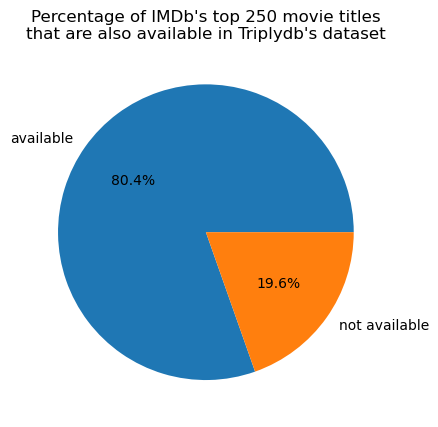

In [6]:
# Plot availability of source movies
src_available = mov_available["title"].sum()
src_unavailable = (~mov_available["title"]).sum()

fig, ax = plt.subplots()

ax.pie(
    [mov_available["title"].sum(), (~mov_available["title"]).sum()],
    labels=["available", "not available"],
    autopct='%1.1f%%'
)

ax.set_title("Percentage of IMDb's top 250 movie titles\nthat are also available in Triplydb's dataset")

plt.show()

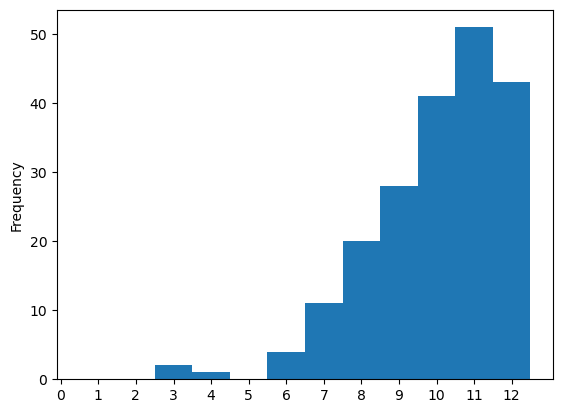

In [7]:
# Plot number of recommended movies that are available (only for available source movies)
fig, ax = plt.subplots()

mov_available[mov_available["title"]].iloc[:, 1:].sum(axis=1).plot(
    kind="hist",
    bins=[i+0.5 for i in range(13)],
    ax=ax
)

ax.set_xticks([i for i in range(13)])
ax.set_xticklabels([i for i in range(13)])

plt.show()

In [8]:
# List of movies that we can use to generate predictions for
imdb_recs_filtered = imdb_recs_raw[mov_available.sum(axis=1) == 13]
imdb_recs_filtered["title"].to_csv("data/available_src_movies.csv", index=False)

## Evaluate Recommendations

### Metrics

**Overlap**

- How many of IMDb's recommendations do we recommend as well?
- Does not consider the order of both rankings.
- Maximum value: 12 (number of recommendations available on IMDb)
- Minimum value: 0

**Intersection Metric**

- How similar are our ranked recommendations to IMDb?
- Does consider the order of both rankings.
- Calculates the overlap values at each rank (normalized by the rank) and averages them.
- Similar to Fagin et al. 2003 - "Comparing top k lists".
- Also described as Average Overlap in Webber et al. 2010 - "A Similarity Measure for Indefinite Rankings".
- Maximum value: 1 (rankings are exactly the same, including their order)
- Minimum value: 0 (rankings are disjoint)

In [9]:
def overlap(r1, r2):
    """
    Use this function to measure the overlap of our recommendations and the
    recommendations made by IMDb. The function returns an integer which
    shows how many movies appear in both recommendation lists.
    """
    intersection = [e for e in r1 if e in r2]
    return len(intersection)


def intersection_metric(r1, r2):
    """
    Similar to Fagin et al. 2003 - "Comparing top k lists", also described as
    Average Overlap in Webber et al. 2010 - "A Similarity Measure for Indefinite
    Rankings".

    The overlap is calculated at each rank from the elements in both lists that
    appear before and at this rank. This value is normalized with the rank. The
    average of these values is returned.

    The maximum value is 1 - the rankings are exactly the same, the minimum
    value is 0 - the rankings are disjoint.
    """
    overlap_vals = []
    for i in range(max([len(r1), len(r2)])):
       overlap_vals.append(overlap(r1[:i+1], r2[:i+1]))
    norm_overlap_vals = [o / (i+1) for i, o in enumerate(overlap_vals)]
    return sum(norm_overlap_vals) / len(norm_overlap_vals)

### Evaluate Random Recommendations

Recommend 10 randomly selected movies for every movie.

In [10]:
# Random recommendations to test code
# Recommend 10 random movies for every movie
rand_recs = pd.DataFrame(
    [[title] + imdb_recs_filtered["title"].sample(n=12, random_state=0).to_list() for title in imdb_recs_filtered["title"]],
    columns=["title"] + [f"rec{i}" for i in range(1, 13)]
)

rand_recs.head()

,title,rec1,rec2,rec3,rec4,rec5,rec6,rec7,rec8,rec9,rec10,rec11,rec12
0,The Shawshank Redemption,Come and See,The Silence of the Lambs,To Kill a Mockingbird,Rebecca,On the Waterfront,The Sting,Ikiru,Barry Lyndon,Goodfellas,2001: A Space Odyssey,Lawrence of Arabia,Yojimbo
1,Dances with Wolves,Come and See,The Silence of the Lambs,To Kill a Mockingbird,Rebecca,On the Waterfront,The Sting,Ikiru,Barry Lyndon,Goodfellas,2001: A Space Odyssey,Lawrence of Arabia,Yojimbo
2,It Happened One Night,Come and See,The Silence of the Lambs,To Kill a Mockingbird,Rebecca,On the Waterfront,The Sting,Ikiru,Barry Lyndon,Goodfellas,2001: A Space Odyssey,Lawrence of Arabia,Yojimbo
3,The 400 Blows,Come and See,The Silence of the Lambs,To Kill a Mockingbird,Rebecca,On the Waterfront,The Sting,Ikiru,Barry Lyndon,Goodfellas,2001: A Space Odyssey,Lawrence of Arabia,Yojimbo
4,Rebecca,Come and See,The Silence of the Lambs,To Kill a Mockingbird,Rebecca,On the Waterfront,The Sting,Ikiru,Barry Lyndon,Goodfellas,2001: A Space Odyssey,Lawrence of Arabia,Yojimbo


In [11]:
# Overlap and Intersection Metric of the 10 random predictions for every movie

evaluation_results_random = pd.DataFrame()

for title in imdb_recs_filtered["title"]:
    title_imdb_recs = imdb_recs_filtered[imdb_recs_filtered["title"] == title].iloc[0, 1:].to_list()
    title_rand_recs = rand_recs[rand_recs["title"] == title].iloc[0, 1:].to_list()

    overlap_val = overlap(title_imdb_recs, title_rand_recs)
    intersection_metric_val = intersection_metric(title_imdb_recs, title_rand_recs)

    evaluation_results_random = pd.concat([
        evaluation_results_random,
        pd.DataFrame({"title": [title], "overlap": [overlap_val], "intersection_metric": [intersection_metric_val]})
    ], ignore_index=True)

evaluation_results_random

,title,overlap,intersection_metric
0,The Shawshank Redemption,0,0.000000
1,Dances with Wolves,0,0.000000
2,It Happened One Night,2,0.120343
3,The 400 Blows,0,0.000000
4,Rebecca,0,0.000000
5,Cool Hand Luke,3,0.167833
6,Groundhog Day,0,0.000000
7,Platoon,0,0.000000
8,The Deer Hunter,0,0.000000
9,In the Name of the Father,1,0.084990


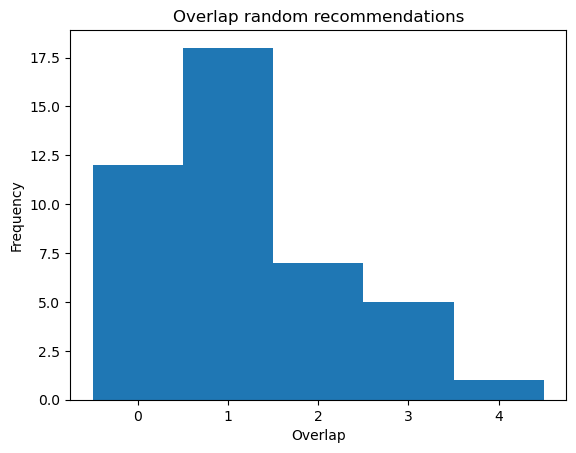

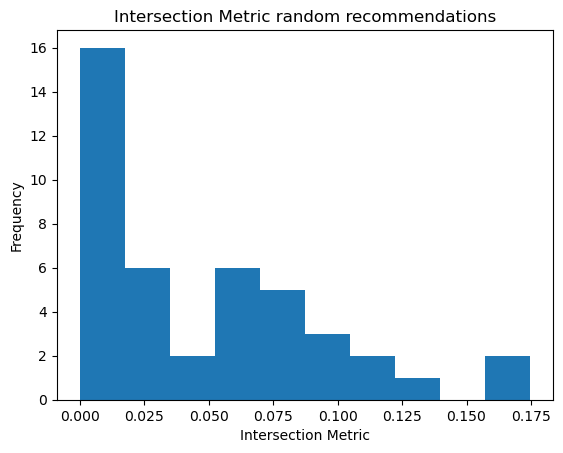

In [12]:
evaluation_results_random["overlap"].plot(
    kind="hist",
    bins=[i-0.5 for i in range(evaluation_results_random["overlap"].max() + 2)],
    title="Overlap random recommendations",
    xlabel="Overlap"
)

plt.show()

evaluation_results_random["intersection_metric"].plot(
    kind="hist",
    title="Intersection Metric random recommendations",
    xlabel="Intersection Metric"
)

plt.show()

In [13]:
# Calculate average overlap and Intersection Metric values
print(f"Average overlap: {evaluation_results_random['overlap'].mean()}")
print(f"Average Intersection Metric: {evaluation_results_random['intersection_metric'].mean()}")

Average overlap: 1.186046511627907
Average Intersection Metric: 0.04756815105652316


### Evaluate Knowledge Graph Recommendations

In [14]:
# Read knowledge graphs recommendations file
kg_recs = pd.read_csv("data/available_src_movies_recs.csv", header=None, names=["title"] + [f"rec{i}" for i in range(1, 13)])

kg_recs.head()

,title,rec1,rec2,rec3,rec4,rec5,rec6,rec7,rec8,rec9,rec10,rec11,rec12
0,The Shawshank Redemption,The Green Mile,The Hurricane,The Mist,Cadillac Man,Project X,Nuts,A Beautiful Mind,No Country for Old Men,Lean on Me,The Bucket List,Fahrenheit 451,The Brazilian Job
1,Dances with Wolves,Open Range,The Postman,The Postman,Mr. Brooks,Message in a Bottle,Swing Vote,The Bodyguard,Wyatt Earp,Young Guns II,Young Guns,Geronimo: An American Legend,Maverick
2,It Happened One Night,Mr. Deeds Goes to Town,Broadway Bill,Lady for a Day,You Can't Take It with You,Lost Horizon,Meet John Doe,Mr. Smith Goes to Washington,The Awful Truth,One Night of Love,Dirigible,The Smiling Lieutenant,Libeled Lady
3,The 400 Blows,Love on the Run,Antoine and Colette,Stolen Kisses,Jules and Jim,Bed & Board,Les mistons,Le Dernier Métro,Breathless,L'Enfant sauvage,Day for Night,Une histoire d'eau,Two English Girls
4,Rebecca,Suspicion,Foreign Correspondent,Jamaica Inn,Spellbound,Laura,Sabotage,The 39 Steps,Lured,Saboteur,Number 13,Waterloo Bridge,Vertigo


In [15]:
# Overlap and Intersection Metric of the 10 random predictions for every movie

evaluation_results_kg = pd.DataFrame()

for title in imdb_recs_filtered["title"]:
    title_imdb_recs = imdb_recs_filtered[imdb_recs_filtered["title"] == title].iloc[0, 1:].to_list()
    title_kg_recs = kg_recs[kg_recs["title"] == title].iloc[0, 1:].to_list()

    overlap_val = overlap(title_imdb_recs, title_kg_recs)
    intersection_metric_val = intersection_metric(title_imdb_recs, title_kg_recs)

    evaluation_results_kg = pd.concat([
        evaluation_results_kg,
        pd.DataFrame({"title": [title], "overlap": [overlap_val], "intersection_metric": [intersection_metric_val]})
    ], ignore_index=True)

evaluation_results_kg

,title,overlap,intersection_metric
0,The Shawshank Redemption,1,0.054434
1,Dances with Wolves,3,0.115813
2,It Happened One Night,1,0.054434
3,The 400 Blows,4,0.160326
4,Rebecca,2,0.091934
5,Cool Hand Luke,1,0.175268
6,Groundhog Day,0,0.000000
7,Platoon,1,0.068323
8,The Deer Hunter,1,0.068323
9,In the Name of the Father,2,0.189788


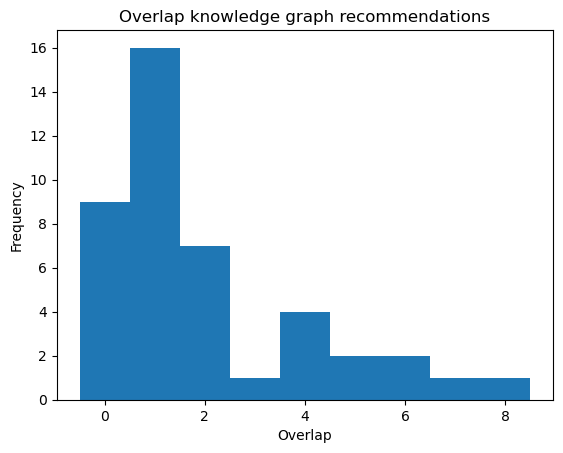

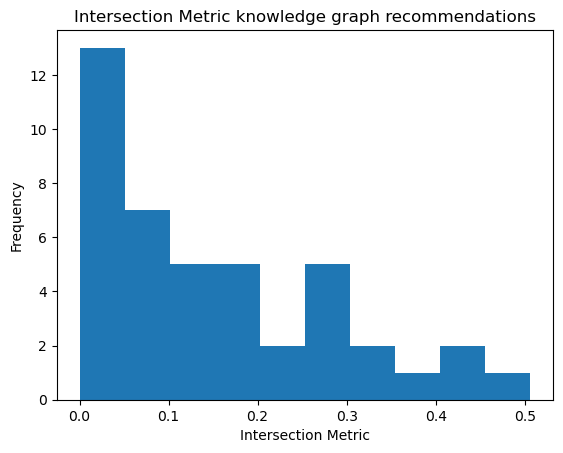

In [16]:
evaluation_results_kg["overlap"].plot(
    kind="hist",
    bins=[i-0.5 for i in range(evaluation_results_kg["overlap"].max() + 2)],
    title="Overlap knowledge graph recommendations",
    xlabel="Overlap"
)

plt.show()

evaluation_results_kg["intersection_metric"].plot(
    kind="hist",
    title="Intersection Metric knowledge graph recommendations",
    xlabel="Intersection Metric"
)

plt.show()

In [17]:
# Calculate average overlap and Intersection Metric values
print(f"Average overlap: {evaluation_results_kg['overlap'].mean()}")
print(f"Average Intersection Metric: {evaluation_results_kg['intersection_metric'].mean()}")

Average overlap: 2.0
Average Intersection Metric: 0.14869549593386802


### Evaluate Embedding Recommendations

In [18]:
# Read knowledge graphs recommendations file
emb_recs = pd.read_csv("data/embedding_movies_recs.csv", header=None, names=["title"] + [f"rec{i}" for i in range(1, 13)])

emb_recs.head()

,title,rec1,rec2,rec3,rec4,rec5,rec6,rec7,rec8,rec9,rec10,rec11,rec12
0,The Shawshank Redemption,Lost Souls,A Thin Line Between Love and Hate,Rendition,My Darling Clementine,The Adventures of Ford Fairlane,Collateral,From Beyond,Happily N'Ever After,The Mighty Quinn,The Squid and the Whale,Waqt,Kal Ho Naa Ho
1,Dances with Wolves,"Ebony, Ivory & Jade",Good Girls Don't,Heart of Darkness,To Live in Peace,The New Big Boss,The Andromeda Strain,Resident Evil: Degeneration,Dellamorte Dellamore,The Secret of Roan Inish,The Princess and the Goblin,White Night Wedding,Revenge of the Pink Panther
2,It Happened One Night,Building a Fire,Sleep,Gunga Din,Charlie's Angels,Over the Fence,Steel Magnolias,The Ballad of Jack and Rose,North by Northwest,Waiting at the Royal,Pitfall,Dear Friends,The Crew
3,The 400 Blows,Airport '77,The Undead,The Young in Heart,The Killers,Games of Love and Chance,Love Letters,Tales from Earthsea,Up Close & Personal,The Magician,Relative Fear,Click,The Apartment
4,Rebecca,Cold Creek Manor,The Road to Hong Kong,Cat Soup,The Genesis Children,Dark Water,Night and the City,Amantes,Freaked,Three Sisters,Resident Evil,Any Which Way You Can,Quartet


In [19]:
# Overlap and Intersection Metric of the 10 random predictions for every movie

evaluation_results_emb = pd.DataFrame()

for title in imdb_recs_filtered["title"]:
    if len(emb_recs[emb_recs["title"] == title]) > 0:
        title_imdb_recs = imdb_recs_filtered[imdb_recs_filtered["title"] == title].iloc[0, 1:].to_list()
        title_emb_recs = emb_recs[emb_recs["title"] == title].iloc[0, 1:].to_list()

        overlap_val = overlap(title_imdb_recs, title_emb_recs)
        intersection_metric_val = intersection_metric(title_imdb_recs, title_emb_recs)

        evaluation_results_emb = pd.concat([
            evaluation_results_emb,
            pd.DataFrame({"title": [title], "overlap": [overlap_val], "intersection_metric": [intersection_metric_val]})
        ], ignore_index=True)
    else:
        print(f'"{title}" not available in the embeddings recommendations.')

evaluation_results_emb

"2001: A Space Odyssey" not available in the embeddings recommendations.


,title,overlap,intersection_metric
0,The Shawshank Redemption,0,0.00000
1,Dances with Wolves,0,0.00000
2,It Happened One Night,0,0.00000
3,The 400 Blows,0,0.00000
4,Rebecca,0,0.00000
5,Cool Hand Luke,0,0.00000
6,Groundhog Day,0,0.00000
7,Platoon,0,0.00000
8,The Deer Hunter,0,0.00000
9,In the Name of the Father,0,0.00000


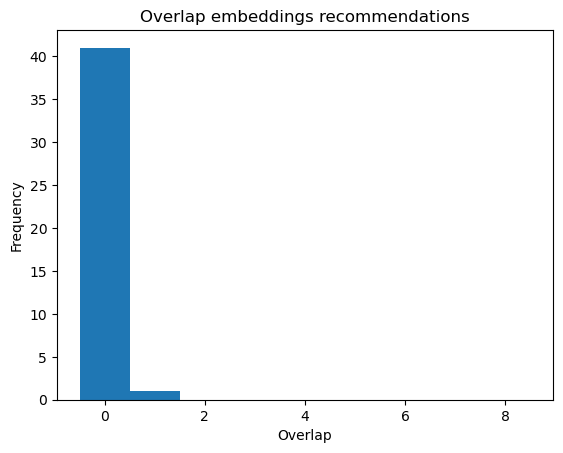

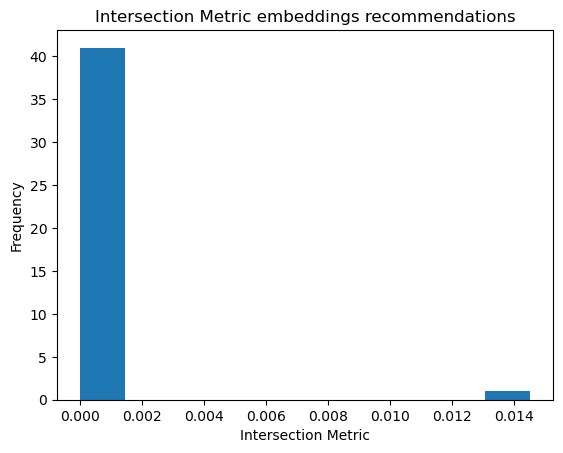

In [20]:
evaluation_results_emb["overlap"].plot(
    kind="hist",
    bins=[i-0.5 for i in range(evaluation_results_kg["overlap"].max() + 2)],
    title="Overlap embeddings recommendations",
    xlabel="Overlap"
)

plt.show()

evaluation_results_emb["intersection_metric"].plot(
    kind="hist",
    title="Intersection Metric embeddings recommendations",
    xlabel="Intersection Metric"
)

plt.show()

In [21]:
# Calculate average overlap and Intersection Metric values
print(f"Average overlap: {evaluation_results_emb['overlap'].mean()}")
print(f"Average Intersection Metric: {evaluation_results_emb['intersection_metric'].mean()}")

Average overlap: 0.023809523809523808
Average Intersection Metric: 0.00034571909571909576


## Similarity between KG and embeddings recommendations

In [22]:
# Overlap and Intersection Metric of the 10 random predictions for every movie

evaluation_results_emb_kg = pd.DataFrame()

for title in kg_recs["title"]:
    if len(emb_recs[emb_recs["title"] == title]) > 0:
        title_kg_recs = kg_recs[kg_recs["title"] == title].iloc[0, 1:].to_list()
        title_emb_recs = emb_recs[emb_recs["title"] == title].iloc[0, 1:].to_list()

        overlap_val = overlap(title_kg_recs, title_emb_recs)
        intersection_metric_val = intersection_metric(title_kg_recs, title_emb_recs)

        evaluation_results_emb_kg = pd.concat([
            evaluation_results_emb_kg,
            pd.DataFrame({"title": [title], "overlap": [overlap_val], "intersection_metric": [intersection_metric_val]})
        ], ignore_index=True)
    else:
        print(f'"{title}" not available in the embeddings recommendations.')

evaluation_results_emb_kg

"2001: A Space Odyssey" not available in the embeddings recommendations.


,title,overlap,intersection_metric
0,The Shawshank Redemption,0,0.000000
1,Dances with Wolves,0,0.000000
2,It Happened One Night,0,0.000000
3,The 400 Blows,0,0.000000
4,Rebecca,0,0.000000
5,Cool Hand Luke,0,0.000000
6,Groundhog Day,0,0.000000
7,Platoon,0,0.000000
8,The Deer Hunter,0,0.000000
9,In the Name of the Father,0,0.000000
